In [4]:
%matplotlib inline

In [5]:
import numpy as np
np.seterr(invalid='ignore')
import matplotlib.pyplot as plt
from scipy.signal import convolve
from tqdm import tqdm

In [58]:
import starry

# Degree of the Ylm expansion
lmax = 5
N = (lmax + 1) ** 2

# Grab the `A1` matrix from `starry`
map = starry.Map(lmax, lazy=False)
A1 = map.ops.A1.eval()

def Ij(j, gamma):
    """
    
    """
    if j == 0:
        return 0.5 * np.pi * (1 - gamma ** 2)
    else:
        return (j - 1) / (j + 2) * (1 - gamma ** 2) * Ij(j - 2, gamma)

    
def sn(n, xi, wsini):
    """
    
    """
    # This is a vector function!
    xi = np.atleast_1d(xi)
    res = np.zeros_like(xi)
    
    # Indices
    L = np.floor(np.sqrt(n))
    D = 0.5 * (n - L ** 2)
    i = int(np.floor(L - D))
    j = int(np.floor(D))
    k = int(np.ceil(D) - np.floor(D))
    
    # x coordinate of lines of constant Doppler shift
    gamma = -xi / wsini
    
    # Integral is only nonzero when we're
    # inside the unit disk
    idx = np.abs(gamma) < 1
    
    # Solve the integral
    if (k == 0) and (j % 2 == 0):
        res[idx] = (2 * gamma[idx] ** i * (1 - gamma[idx] ** 2) ** (0.5 * (j + 1))) / (j + 1)
    elif (k == 1) and (j % 2 == 0):
        res[idx] = gamma[idx] ** i * Ij(j, gamma[idx])
    
    return res


def s(xi, wsini):
    """
    
    """
    res = np.zeros((N, len(xi)))
    for n in range(N):
        res[n] = sn(n, xi, wsini)
    return res


def g(xi, wsini):
    """
    
    """
    # A1 is a sparse scipy matrix, so `*` 
    # is actually how we dot matrices!
    return s(xi, wsini).T * A1

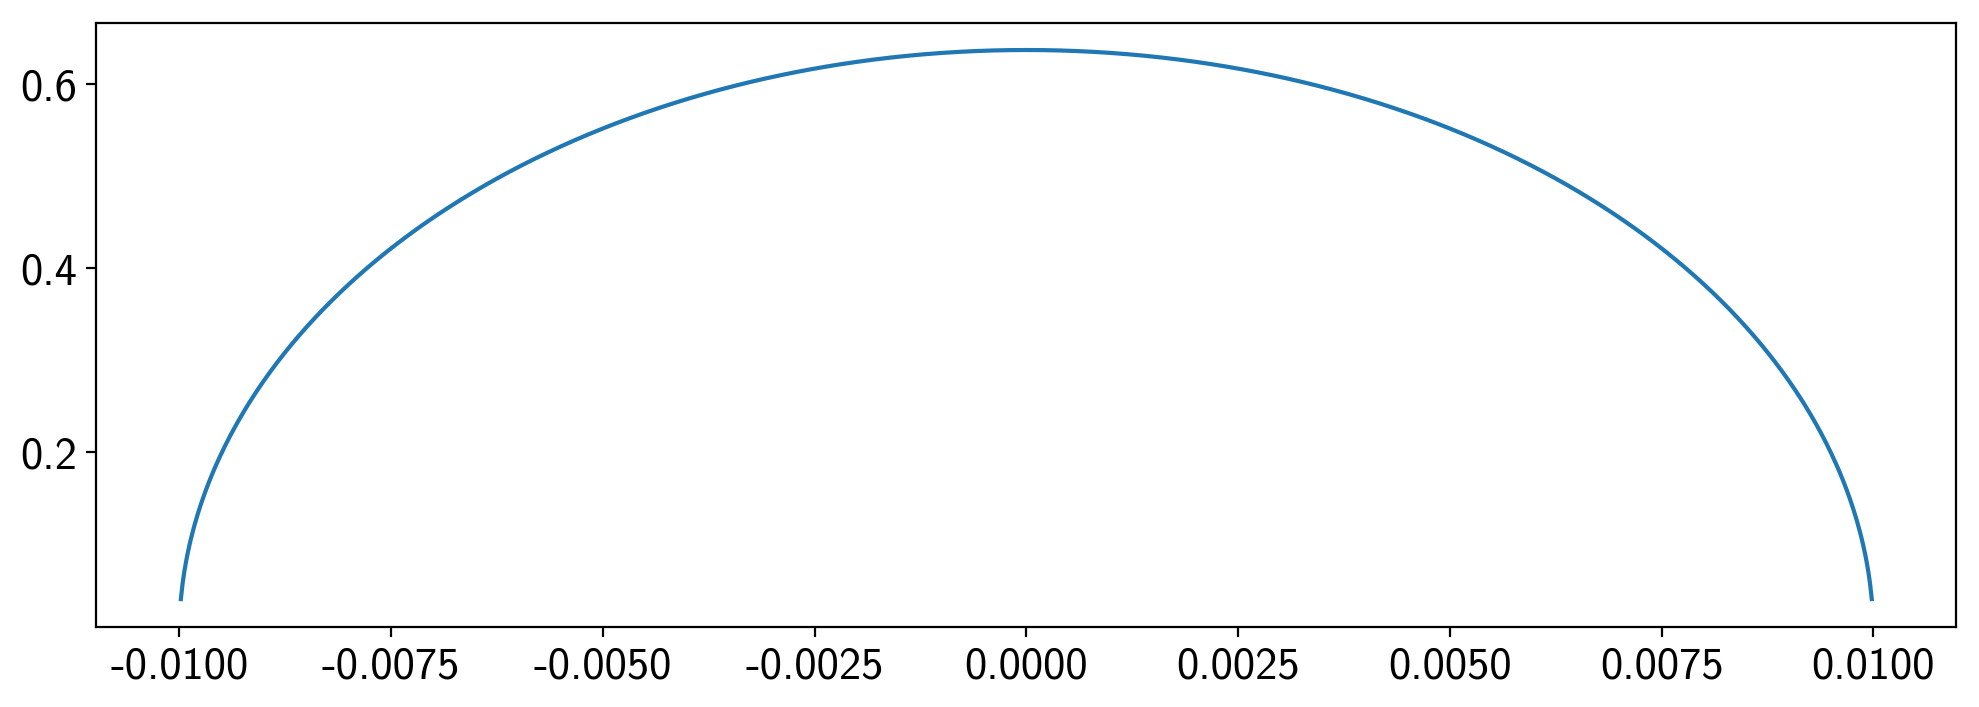

In [59]:
ntau = 1001
w = 1e-2
tau = np.linspace(-w, w, ntau)
g00 = g(tau, w)[:, 0]
nonzero = g00 != 0
tau = tau[nonzero]
g00 = g00[nonzero]
ntau = len(tau)
plt.plot(tau, g00);

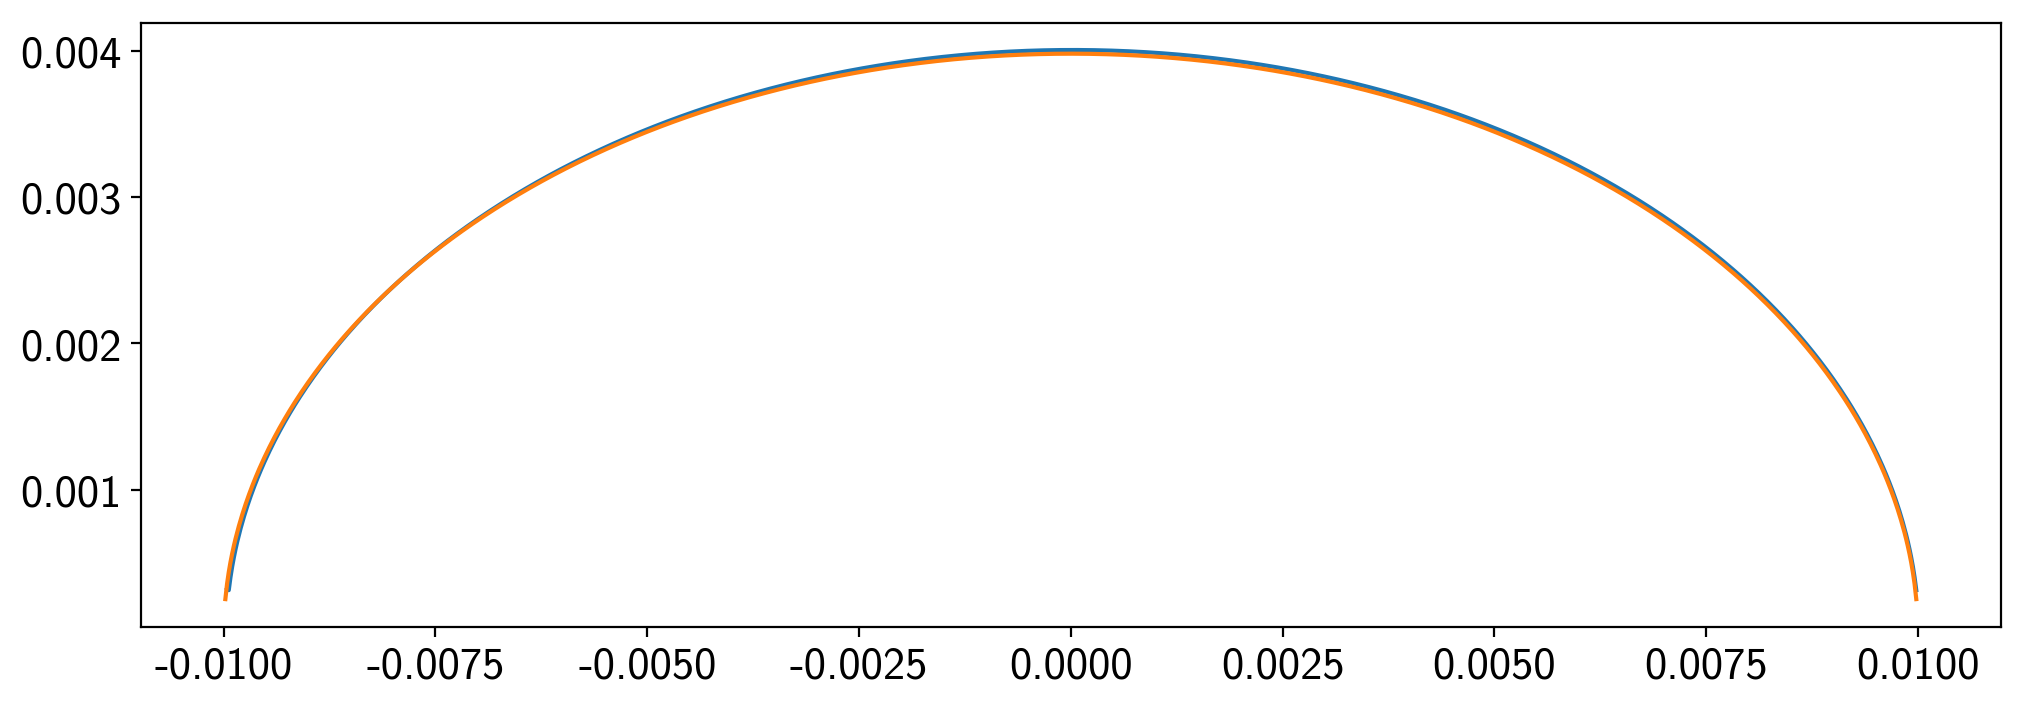

In [87]:
k = np.fft.rfftfreq(ntau, (tau[1] - tau[0]))
fg00 = jv(1, 2 * k * np.pi * w) / (k * w)
fg00[0] = np.pi
plt.plot(tau[1:], np.roll(np.fft.irfft(fg00), ntau // 2))
plt.plot(tau, 0.00625 * g00);

$$
\mathrm{Re}[\mathrm{e}^{2\pi i k \omega x}] = \cos(2\pi k \omega x) \\
\mathrm{Im}[\mathrm{e}^{2\pi i k \omega x}] = \sin(2\pi k \omega x)
$$

E

X

P

E

R

I

M

E

N

T

I

N

G

In [ ]:
def doppler_field(x, y, w=0.01, inc=90, alpha=0, cb=0):
    """
    The (log) Doppler field for the general case of
    a differentially-rotating star with convective 
    blueshift.

    """
    sini = np.sin(inc * np.pi / 180)
    cosi = np.cos(inc * np.pi / 180)
    z = np.sqrt(1 - x ** 2 - y ** 2)
    beta = w * sini * x * (1 - alpha * (sini * y + cosi * z) ** 2) + z * cb
    return np.log(1 - beta)

In [ ]:
# Field parameters
w = 0.01
inc = 60
alpha = 0.0
cb = 0.0

# Plot the image
x = np.linspace(-1, 1, 1000)
y = np.linspace(-1, 1, 1000)
x, y = np.meshgrid(x, y)
z = np.sqrt(1 - x ** 2 - y ** 2)
fig, ax = plt.subplots(1)
D = doppler_field(x, y, w=w, inc=inc, alpha=alpha, cb=cb)
ax.imshow(D, origin="lower", extent=(-1, 1, -1, 1))
ax.contour(D, origin="lower", colors="k", extent=(-1, 1, -1, 1), levels=10);
ax.axis('off');

In [ ]:
# Discretize the surface
import starry_beta

res = 3000
ydeg = 10
Ny = (ydeg + 1) ** 2
map_beta = starry_beta.Map(ydeg)

x, y = np.meshgrid(np.linspace(-1, 1, res), np.linspace(-1, 1, res))
inside = x ** 2 + y ** 2 < 1
x = x[inside]
y = y[inside]
npts = len(x)

def Ylm(l, m):
    map_beta.reset()
    if l != 0:
        map_beta[l, m] = 1.0
        return map_beta(x=x, y=y) - 1.0 / np.pi
    else:
        return map_beta(x=x, y=y)

In [ ]:
# Compute the Doppler field
D = doppler_field(x, y, w=w, inc=inc, alpha=alpha, cb=cb)

In [ ]:
# Discretize the transform
ntau = 101 # This number *must* be odd!
tau = np.linspace(np.min(D), np.max(D), ntau)
dtau = tau[1] - tau[0]
bins = np.append(tau - 0.5 * dtau, [tau[-1] + 0.5 * dtau])

In [ ]:
g00, _ = np.histogram(D, weights=Ylm(0, 0) * ntau / npts, bins=bins)

In [ ]:
plt.plot(tau, g00);

In [ ]:
sini = np.sin(inc * np.pi / 180)
k = np.fft.rfftfreq(ntau, dtau)
fg00 = np.pi - (4. / 3.) * cb * k * np.pi ** 2 * 1j

In [ ]:
plt.plot(fg00.real)
plt.plot(np.fft.rfft(g00).real)